<a href="https://colab.research.google.com/github/Francimaria/Sistemas_de_Multiplos_Classificadores/blob/main/mcs_exe_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deslib

     |████████████████████████████████| 163kB 8.6MB/s 


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
import pandas as pd
import numpy as np
from collections import Counter

from scipy.io import arff
import urllib.request
import io

import operator
from functools import partial
from deslib.util.instance_hardness import kdn_score

from sklearn.linear_model import Perceptron
from sklearn.ensemble import BaggingClassifier
from sklearn.calibration import CalibratedClassifierCV

from deslib.dcs import OLA, LCA, MCB
from deslib.des import KNORAU
from deslib.des.knora_e import KNORAE
from deslib.static import (StackedClassifier,SingleBest,StaticSelection)

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE

load dataset .. 

Dois bancos de dados binários e com atributos numéricos do [repositório Promise](http://promise.site.uottawa.ca/SERepository/datasets-page.html).

In [4]:
def load_data(full_filepath, url=False): 
	if url:
		ftpstream = urllib.request.urlopen(full_filepath)
		data, _ = arff.loadarff(io.StringIO(ftpstream.read().decode('utf-8')))
	else: 
		data, _ = arff.loadarff(full_filepath) 

	df = pd.DataFrame(data)
	df.dropna(inplace=True)
	df[df.columns[-1]] = df.apply(lambda x:  x[df.columns[-1]].decode(), axis=1)
		
	labels = pd.DataFrame(df[df.columns[-1]])
	instances = df.drop([df.columns[-1]], axis=1)
   
  # pre-processing 
	print('Original dataset shape %s' % labels.value_counts())
	sm = SMOTE(random_state=42)
	instances, labels = sm.fit_resample(instances, labels)
	print('Resampled dataset shape %s' % Counter(labels)) 
	instances = pd.DataFrame(preprocessing.scale(instances))
  #replace labels 
	labels = pd.DataFrame(labels)
	labels = labels.replace(["false", "true"],[0,1])  
	return instances,labels

In [5]:
cm1 = "https://raw.githubusercontent.com/Francimaria/Sistemas_de_Multiplos_Classificadores/main/Exercicio-3/data/cm1.arff"
kc1 = "https://raw.githubusercontent.com/Francimaria/Sistemas_de_Multiplos_Classificadores/main/Exercicio-3/data/kc1.arff"
datasets_filenames = [cm1, kc1]
datasets_names = ['cm1','kc1']

instances ={}
labels = {}

print("load data")
for name, file_name in zip(datasets_names, datasets_filenames):
  print(name)
  instances[name], labels[name] = load_data(file_name, url=True)

load data
cm1
Original dataset shape defects
false      449
true        49
dtype: int64
Resampled dataset shape Counter({'false': 449, 'true': 449})
kc1
Original dataset shape defects
false      1783
true        326
dtype: int64
Resampled dataset shape Counter({'false': 1783, 'true': 1783})


Suponha três variantes do conjunto de validação:

(a) o conjunto original 𝒱; 

(b) o conjunto 𝒱’ contendo apenas as instâncias difíceis (kDN > 0,5) de 𝒱;

(c) o conjunto 𝒱’ contendo apenas as instâncias fáceis (kDN <= 0,5) de 𝒱.

In [22]:
threshold = 0.5

kdn_conf = [("V_0", partial(operator.gt, 2)), ("V_1", partial(operator.lt, threshold)), ("V_2", partial(operator.gt, threshold))]

In [23]:
def _filter_based_hardness(instances, labels, hards, op):

  triples = [(instances[i], labels[i], hards[i]) for i in range(len(hards))]

  return filter(lambda t: op(t[2]), triples)

In [24]:
def select_val_set(instances, labels, kdn_config, k):
  
  kdn_scores, neighbors = kdn_score(instances,labels.flatten(), k)

  filtered = _filter_based_hardness(instances, labels, kdn_scores, kdn_config)

  X_val = []
  y_val = []

  for t in filtered:
    X_val.append(t[0])
    y_val.append(t[1])

  return np.array(X_val), np.array(y_val)

taxa de acerto, AUC, g-mean e f-measure

In [25]:
def get_metrics(method, X_test):
  y_predict = method.predict(X_test)
  y_score = method.predict_proba(X_test)[:, 1]

  df_result = pd.DataFrame(columns = ['taxa_acerto','AUC', 'gmean','fmeasure']) 
  new_row = {'taxa_acerto': accuracy_score(y_test,y_predict),
            'AUC': roc_auc_score(y_test,y_predict),
            'gmean': geometric_mean_score(y_test,y_predict),
            'fmeasure': f1_score(y_test,y_predict)}
  df_result = df_result.append(new_row, ignore_index=True)
        
  return df_result

In [33]:
def average_metrics(datasets_names, methods, n_folds, metrics):
  df_result_avg = pd.DataFrame(columns = ['dataset','KDN','metodo','taxa_acerto_mean','taxa_acerto','AUC', 'gmean','fmeasure']) 
  taxa_acerto,auc,gmean,fmeasure = [],[],[],[]
  for ds_name in datasets_names:
    for method in methods:
      for hardness_type, filter_func in kdn_conf:      
        for fold in range(1,n_folds):
          data = metrics_results[ds_name][fold][hardness_type][method]
          taxa_acerto.append(data.taxa_acerto[0])
          auc.append(data.AUC[0])
          gmean.append(data.gmean[0])
          fmeasure.append(data.fmeasure[0])
        new_row = {'dataset':ds_name,
                    'KDN': hardness_type,                   
                    'metodo':method,
                    'taxa_acerto_mean': np.mean(taxa_acerto),
                    'taxa_acerto': "%0.3f (%0.3f)" % (np.mean(taxa_acerto), np.std(taxa_acerto)),
                    'AUC': "%0.3f (%0.3f)" % (np.mean(auc), np.std(auc)),
                    'gmean': "%0.3f (%0.3f)" % (np.mean(gmean),np.std(gmean)),
                    'fmeasure': "%0.3f (%0.3f)" % (np.mean(fmeasure),np.std(fmeasure))}
        df_result_avg = df_result_avg.append(new_row, ignore_index=True)
  return df_result_avg       

K-fold

In [34]:
metrics_results = {}
n_folds = 10
rng = 0 
base_model = CalibratedClassifierCV(base_estimator = Perceptron(random_state=rng))

for ds_name in datasets_names: 
  print("Dataset name: ", ds_name)
  X = instances[ds_name]
  y = labels[ds_name]

  metrics_results[ds_name] = {}

  skf = StratifiedKFold(n_splits=n_folds,random_state=rng)
  # select 5 neighborns
  k = 5  

  # split the dataset into 7 folds to train, 2 to validation, and 1 to test
  val_size = 0.20

  for fold, division in enumerate(skf.split(X, y), 1):
    train_index, test_index = division[0], division[1] 

    train, valid = train_test_split(train_index, test_size=val_size)

    X_train, X_valid, X_test = X.iloc[train], X.iloc[valid], X.iloc[test_index]
    y_train, y_valid, y_test = y.iloc[train], y.iloc[valid], y.iloc[test_index]   

    metrics_results[ds_name][fold] = {}

    # Use the KDN to select the validation set
    for hardness_type, filter_func in kdn_conf:
      X_val, y_val = select_val_set(np.array(X_valid), np.array(y_valid), filter_func, k)      
      
      pool_classifiers = BaggingClassifier(base_estimator=base_model, n_estimators=100, random_state=rng)
      pool_classifiers.fit(X_train, y_train)

      # Métodos estáticos
      single_best = SingleBest(pool_classifiers)
      static_selection = StaticSelection(pool_classifiers)      

      #Inicialização das técnicas de seleção dinâmica (região de competência igual a 7)
      ola = OLA(pool_classifiers,k=7, random_state=rng)
      lca = LCA(pool_classifiers,k=7, random_state=rng)
      mcb = MCB(pool_classifiers,k=7, random_state=rng)

      knorau = KNORAU(pool_classifiers, k=7, random_state=rng)
      kne = KNORAE(pool_classifiers, k=7, random_state=rng)
      
      names = ['Single Best', 'Static Selection',
               'OLA', 'LCA','MCB','KNORA-U', 'KNORA-E']
      
      methods = [single_best, static_selection,
                 ola, lca, mcb, knorau, kne]
      
      metrics_results[ds_name][fold][hardness_type] = {}

      for method, name in zip(methods, names):
        method.fit(X_val, y_val)
        metrics_results[ds_name][fold][hardness_type][name] = get_metrics(method, X_test)

Dataset name:  cm1
Dataset name:  kc1


In [36]:
df_result = average_metrics(datasets_names,names,n_folds,metrics_results)
df_result.to_csv("/content/df_result_avg.csv", index=False)
df_result.to_latex("/content/df_result_avg.tex",index=False)
df_result

,dataset,KDN,metodo,taxa_acerto_mean,taxa_acerto,AUC,gmean,fmeasure
0,cm1,V_0,Single Best,0.775087,0.775 (0.067),0.775 (0.067),0.773 (0.068),0.776 (0.060)
1,cm1,V_1,Single Best,0.755972,0.756 (0.075),0.756 (0.075),0.746 (0.087),0.734 (0.103)
2,cm1,V_2,Single Best,0.761946,0.762 (0.070),0.762 (0.070),0.754 (0.080),0.748 (0.091)
3,cm1,V_0,Static Selection,0.769569,0.770 (0.070),0.769 (0.070),0.763 (0.078),0.758 (0.086)
4,cm1,V_1,Static Selection,0.771910,0.772 (0.067),0.772 (0.067),0.766 (0.074),0.760 (0.081)
5,cm1,V_2,Static Selection,0.775332,0.775 (0.068),0.775 (0.068),0.770 (0.073),0.765 (0.079)
6,cm1,V_0,OLA,0.778477,0.778 (0.067),0.778 (0.067),0.774 (0.072),0.772 (0.077)
7,cm1,V_1,OLA,0.772193,0.772 (0.070),0.772 (0.070),0.766 (0.077),0.761 (0.087)
8,cm1,V_2,OLA,0.774307,0.774 (0.069),0.774 (0.069),0.768 (0.076),0.765 (0.085)
9,cm1,V_0,LCA,0.773394,0.773 (0.066),0.773 (0.066),0.767 (0.073),0.765 (0.081)


**Plot gráficos**

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

Dataset :  cm1
/content/result_cm1.png


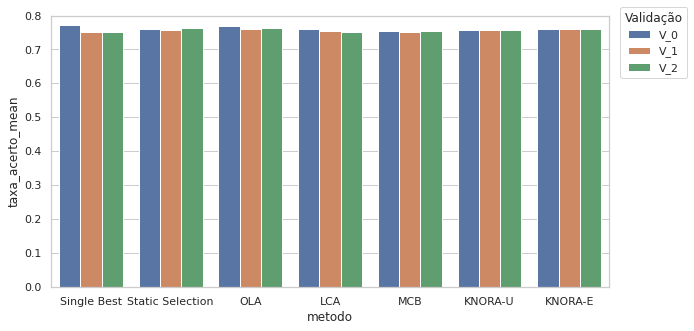

Dataset :  kc1
/content/result_kc1.png


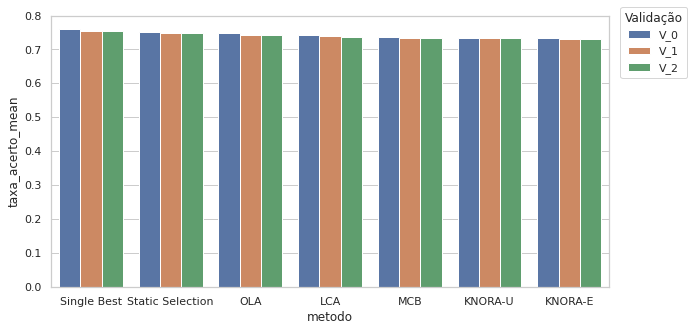

In [32]:
sns.set_theme(style="whitegrid")

for ds_name in datasets_names:
    print("Dataset : ", ds_name)
    df_data = df_result.loc[(df_result['dataset'] == ds_name)]
    fig = plt.figure(figsize=(10,5))      
    ax = sns.barplot(x="metodo", y="taxa_acerto_mean",ci="Oracle_std", hue="KDN", data=df_data)
    plt.ylim(0.0, 0.8)
    ax.legend(loc='center right',bbox_to_anchor=(1.15, 0.9), ncol=1, title="Validação")
    file_name = '/content/result_' + str(ds_name) +'.png'
    print(file_name)
    fig.savefig(file_name)
    plt.show()